Loading Temperature Data...
Loading ti Data...
Loading alb Data...
Generating Plots...
Nighttime surface temperature - Slope: 0.4628, P-value: 2.0468e-08
Daytime surface temperature - Slope: 0.6585, P-value: 1.5561e-11
Thermal inertia - Slope: 0.0000, P-value: 9.4393e-01
Albedo - Slope: -0.0055, P-value: 1.1913e-12


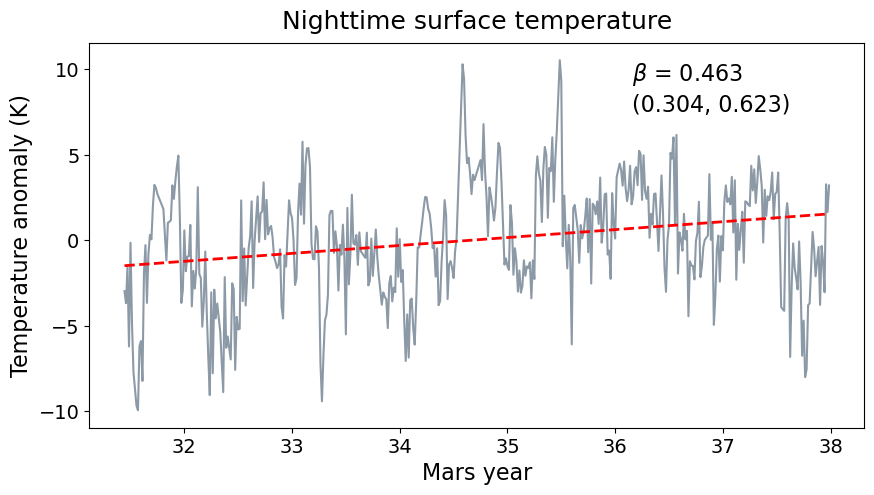

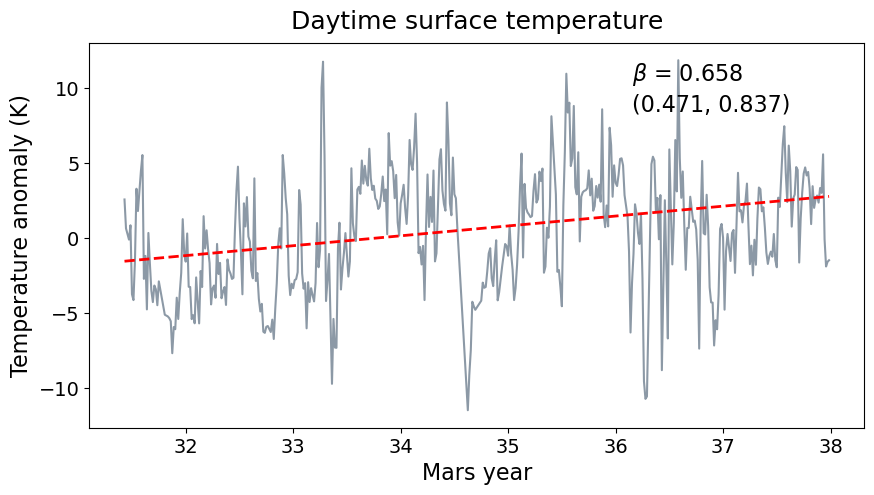

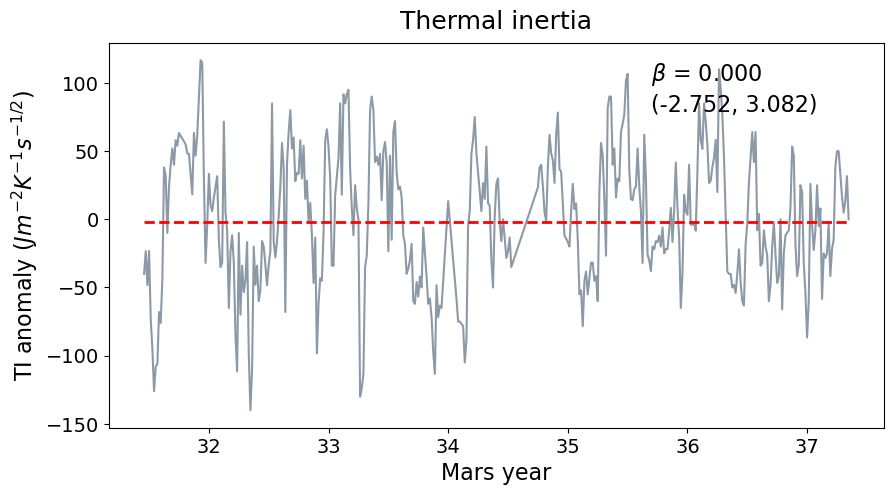

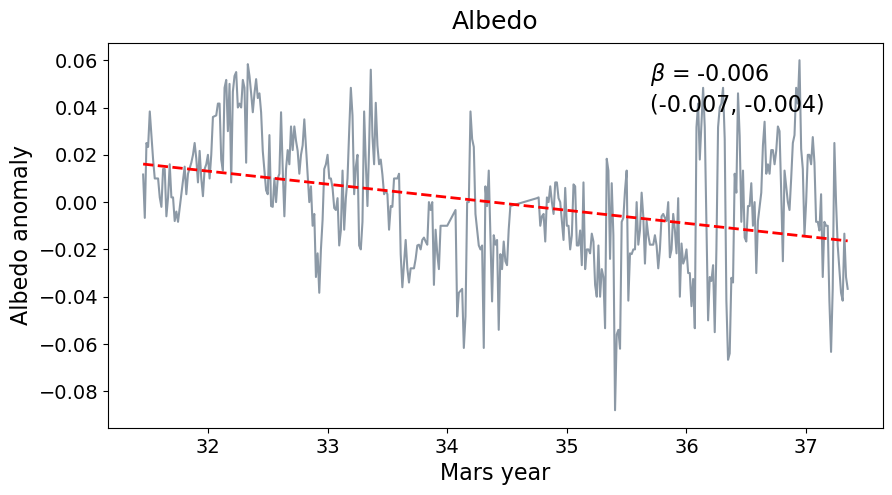

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import theilslopes
import pymannkendall as mk
import marstime as mt
import warnings

# Configuration
# ---------------------------------------------------------
# Set your paths here
PATH_DATA_TEMP = '../data/MSL_TEMP_5min_SOL4354_level0111.csv'
PATH_DATA_ALB_TI = "../data/alb_ti_SOL4354.nc"

warnings.filterwarnings("ignore")

# 1. Helper Functions for Data Processing
# ---------------------------------------------------------

def process_msl_temperature_data(csv_path, ltst_interval=1, ls_interval=5):
    """Reads and bins MSL temperature data from CSV."""
    print("Loading Temperature Data...")
    df = pd.read_csv(csv_path)
    df['Time'] = pd.to_datetime(df['Time'])
    
    # Calculate Mars Time (MY and Ls)
    julian_date = pd.DatetimeIndex(df['Time']).to_julian_date()
    date_tt = mt.julian_tt(julian_date)
    j2000_offset = mt.j2000_offset_tt(date_tt)
    df['MY'] = mt.Clancy_Year(j2000_offset)
    df['Ls'] = mt.Mars_Ls(j2000_offset)

    # Binning logic
    df['LTST'] = np.round(df['LTST'] / ltst_interval) * ltst_interval 
    df.loc[df['LTST'] == 24, 'LTST'] = 0
    df['Ls'] = np.round(df['Ls'] / ls_interval) * ls_interval
    
    # Handle Ls wrapping
    mask_360 = df['Ls'] == 360
    df.loc[mask_360, 'MY'] += 1
    df.loc[mask_360, 'Ls'] = 0
    
    # Calculate median for bins
    df_grouped = df.groupby(['MY', 'LTST', 'Ls']).median().reset_index()
    return df_grouped

def prepare_temp_anomaly(df, target_ltst, var_name='GTS'):
    """Extracts specific LTST, calculates anomalies, and prepares time series."""
    # Filter by hour
    df_hour = df[df['LTST'] == target_ltst].copy()
    
    # Convert to Xarray for easy handling
    df_set = df_hour[['MY', 'Ls', var_name]].set_index(['MY', 'Ls'])
    da = df_set.to_xarray()[var_name]
    
    # Calculate Anomaly
    da_mean = da.mean(dim='MY')
    da_anom = da - da_mean
    
    # Regrid to 1D time axis
    x, y = regrid_to_linear_time(da_anom)
    
    # Filter outliers (3-sigma rule)
    mask = np.abs(y) < 3 * np.nanstd(y)
    return x[mask], y[mask]

def prepare_surface_prop_anomaly(nc_path, var_name):
    """Reads NetCDF for Albedo/TI, masks dust storm, and calculates anomalies."""
    print(f"Loading {var_name} Data...")
    ds = xr.open_dataset(nc_path)
    da = ds[var_name]
    
    # Mask Global Dust Storm (MY34, Ls 190-260)
    mask_gds = (da.MY == 34) & (da.Ls > 190) & (da.Ls < 260)
    da = da.where(~mask_gds)
    
    # Calculate Anomaly
    da_mean = da.mean(dim='MY')
    da_anom = da - da_mean
    
    # Regrid to 1D time axis
    return regrid_to_linear_time(da_anom)

def regrid_to_linear_time(data_array):
    """Flattens MY and Ls dimensions into a single linear MY time axis."""
    # Stack MY and Ls to create a linear time coordinate
    # Use meshgrid logic to ensure alignment if using xarray
    MY, Ls = np.meshgrid(data_array.coords['MY'], data_array.coords['Ls'], indexing='ij')
    
    # Calculate linear time: MY + fraction of year
    time_linear = (MY + Ls / 360).flatten()
    data_values = data_array.values.flatten()
    
    # Remove NaNs
    mask = ~np.isnan(data_values)
    return time_linear[mask], data_values[mask]

# 2. Statistical Analysis
# ---------------------------------------------------------

def calculate_stats(x, y):
    """Calculates Theil-Sen slope and Mann-Kendall p-value."""
    slope, intercept, lower_slope, upper_slope = theilslopes(y, x)
    p_value = mk.original_test(y).p
    return slope, intercept, lower_slope, upper_slope, p_value

# 3. Plotting
# ---------------------------------------------------------

def plot_trend(ax, x, y, slope, intercept, lower, upper, title, ylabel):
    """Generates the standardized trend plot on a specific axis."""
    
    # Fit line
    x_fit = np.linspace(x.min(), x.max(), len(x))
    y_fit = slope * x_fit + intercept
    
    # Plot Data
    ax.plot(x, y, c='slategrey', linewidth=1.5, alpha=0.8)
    ax.plot(x_fit, y_fit, c='red', linestyle='--', linewidth=2)
    
    # Statistics Text
    # Dynamic positioning for text based on data range
    y_range = y.max() - y.min()
    text_y_pos = y.max() - 0.1 * y_range
    
    # Format text (beta and CI)
    ax.text(0.70, 0.90, r'$\beta$ ' + f'= {slope:.3f}', transform=ax.transAxes, fontsize=16)
    ax.text(0.70, 0.82, f'({lower:.3f}, {upper:.3f})', transform=ax.transAxes, fontsize=16)
    
    # Styling
    ax.set_title(title, loc='center', fontsize=18, pad=10)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel('Mars year', fontsize=16)
    ax.tick_params(labelsize=14)
    # ax.grid(True, linestyle=':', alpha=0.6)

# 4. Main Execution
# ---------------------------------------------------------

def main():
    # --- Prepare FigSI9 Data (Temperature) ---
    # Load raw data once
    df_msl = process_msl_temperature_data(PATH_DATA_TEMP, ltst_interval=0.5, ls_interval=5)
    
    # Nighttime (LTST 3)
    x_night, y_night = prepare_temp_anomaly(df_msl, target_ltst=3, var_name='GTS')
    stats_night = calculate_stats(x_night, y_night)
    
    # Daytime (LTST 15)
    x_day, y_day = prepare_temp_anomaly(df_msl, target_ltst=15, var_name='GTS')
    stats_day = calculate_stats(x_day, y_day)

    # --- Prepare FigSI10 Data (Alb/TI) ---
    # Thermal Inertia
    x_ti, y_ti = prepare_surface_prop_anomaly(PATH_DATA_ALB_TI, 'ti')
    stats_ti = calculate_stats(x_ti, y_ti)
    
    # Albedo
    x_alb, y_alb = prepare_surface_prop_anomaly(PATH_DATA_ALB_TI, 'alb')
    stats_alb = calculate_stats(x_alb, y_alb)

    # --- Plotting ---
    print("Generating Plots...")
    
    # Define plot configurations
    plots = [
        {
            'data': (x_night, y_night), 'stats': stats_night,
            'title': 'Nighttime surface temperature',
            'ylabel': 'Temperature anomaly (K)',
        },
        {
            'data': (x_day, y_day), 'stats': stats_day,
            'title': 'Daytime surface temperature',
            'ylabel': 'Temperature anomaly (K)',
        },
        {
            'data': (x_ti, y_ti), 'stats': stats_ti,
            'title': 'Thermal inertia',
            'ylabel': r'TI anomaly ($J m^{-2} K^{-1} s^{-1/2}$)',
        },
        {
            'data': (x_alb, y_alb), 'stats': stats_alb,
            'title': 'Albedo',
            'ylabel': 'Albedo anomaly'
        }
    ]

    # Create individual plots
    for p in plots:
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_trend(
            ax, 
            p['data'][0], p['data'][1], 
            *p['stats'][:4], # unpack slope, intercept, lower, upper
            p['title'], 
            p['ylabel']
        )
        
        # Print P-value for verification
        print(f"{p['title']} - Slope: {p['stats'][0]:.4f}, P-value: {p['stats'][4]:.4e}")
        

if __name__ == "__main__":
    main()